# Manual Implementation of ISOMAP for Facial Image Clustering

This notebook aims to reproduce the ISOMAP algorithm results in the original paper for ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323. The file isomap.mat (or isomap.dat) contains 698 images, corresponding to different poses of the same face. Each image is given as a 64 × 64 luminosity map, hence represented as a vector in R4096. This vector is stored as a row in the file. (This is one of the datasets used in the original paper.)

Isomap stands for isometric mapping and is a non-linear dimensional reduction method that aims to preserve the geodesic distances of our dataset in lower dimensions. Typical dimensionaltiy reduction methods like Principal Component Analysis (PCA) and Singular Value Decomposition run into several limitations. Those methods are usually only suitable when variables are lienarly correlated. Because PCA uses linear projections, this implicitly assumes that Euclidean distance is the dissimilarity (distance) measure. So when non-linear structures exist in our data, Euclidean distance is not a good distance measure globally. 

The key idea of Isomap is to produce a low dimensional representation which preserves the "walking-distance" over our data cloud (manifold). The steps are as followed:

1. Find Neighbors N(i) of each data point, xi, within distance epsilon and let A be the adjacency matrix recording neighbor Euclidean distance. (this epsilon value is our hyperparameter that can be tuned)
2. Find the shortest path distance matrix D between each pair of points, xi and xj, based on A
3. Find low dimensional representation which preserves the distance information in D. 

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import shortest_path
import scipy.sparse.linalg as ll
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math

In [3]:
images = scipy.io.loadmat('data/faces.mat')['images'].T

In [4]:
#Step 1: Build a weighted graph A using nearest neighbors based on epsilon 
A = np.zeros((images.shape[0], images.shape[0]))
    
for i in range(len(images)):
    for j in range(i + 1, len(images)):
        d = np.sqrt(sum((images[i] - images[j])**2))
        A[i][j] = d
        A[j][i] = d

After tuning, I have selected a threshold of 12 for my epsilon. A larger epsilon seems to be unable to capture the full pattern while a smaller threshold would cause an error in the construction of our centering matrix. 

In [24]:
np.random.seed(1)

#after several trials, this seems to be the best value
epsilon = 12 

A[np.where(A > epsilon)] = 0

#Step 2: Compute pairwise shortest distance matrix D
D = shortest_path(A, directed=False)
    
# visualize the weighted adjacency matrix
#plt.imshow(A)
#plt.title('Nearest Neighbor Graph')
#plt.show()
    
# visualize the shortest distance matrix
#plt.imshow(D)
#plt.title('Shortest Distance Matrix')
#plt.show()

(-0.5, 63.5, 63.5, -0.5)

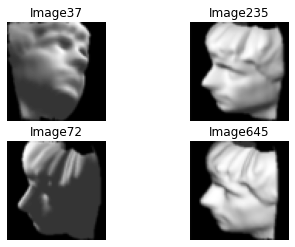

In [10]:
# plot 4 random facial images
images_id = np.random.randint(0, len(images), 4)
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(images[images_id[0]].reshape(64,64).T, cmap = 'gray')
axs[0, 0].set_title('Image' + str(images_id[0]))
axs[0, 0].axis('off')
axs[0, 1].imshow(images[images_id[1]].reshape(64,64).T, cmap = 'gray')
axs[0, 1].set_title('Image' + str(images_id[1]))
axs[0, 1].axis('off')
axs[1, 0].imshow(images[images_id[2]].reshape(64,64).T, cmap = 'gray')
axs[1, 0].set_title('Image' + str(images_id[2]))
axs[1, 0].axis('off')
axs[1, 1].imshow(images[images_id[3]].reshape(64,64).T, cmap = 'gray')
axs[1, 1].set_title('Image' + str(images_id[3]))
axs[1, 1].axis('off')

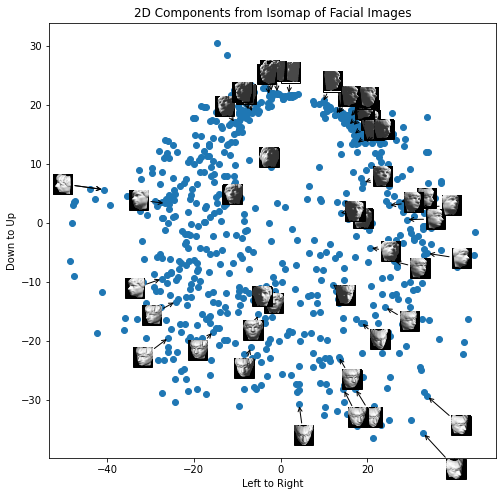

In [23]:
#Step 3: Use a centering matrix H = I - 1/m11^T to get
#C = -0.5 H (D)^@ H
H = np.identity(D.shape[0]) - 1/(D.shape[0]) * np.ones_like(D)
C = -0.5 * H @ (D ** 2) @ H
    
#Step 4: Compute leading eigenvectors W and eigenvalues LAMBDA of C
lam,W = ll.eigs(C,k = 2)
lam = lam.real
W = W.real
    
# calculate the new coordinates Z
Z = W @ np.diag(np.sqrt(lam))
    
# select random images from dataset
images_id = np.random.randint(0, len(images), 50)
        
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(Z[:, 0], Z[:, 1])
ax.set_title('2D Components from Isomap of Facial Images')
ax.set_ylabel('Down to Up')
ax.set_xlabel('Left to Right')
    
for i in images_id:
    face_image = images[i].reshape(64, 64).T
    image = OffsetImage(face_image, zoom=0.3, cmap = 'gray')
    annot = AnnotationBbox(image, Z[i], pad = 0.01, xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"))
    ax.add_artist(annot)

plt.show()

Images that have similar orientations are all clumped close together. For example, images on the left are all facing the left side, images on the right are all looking left, and images at the bottom are all looking down. In other words, our new coordinate system created by the ISOMAP algorithm can capture facial orientation.

In [25]:
#Step 1: calculate sample mean and covariance matrix
mu = np.mean(images, axis = 0)
xc = (images - mu).T
C = np.dot(xc, xc.T)/(xc.shape[1])

#Step 2: find the eigenvectors corresponding to the largest eigenvalues
lam,W = ll.eigs(C,k = 2)
lam = lam.real
W = W.real

#first principal component
dim1 = np.dot(W[:,0].T,xc)/math.sqrt(lam[0])

#second principal component
dim2 = np.dot(W[:,1].T,xc)/math.sqrt(lam[1]) # extract 2nd eigenvalue

#plt.figure(figsize=(8,8))
#plt.scatter(dim1,dim2, marker = "o", c = "red")
#plt.title('2D Components from Isomap of Facial Images')

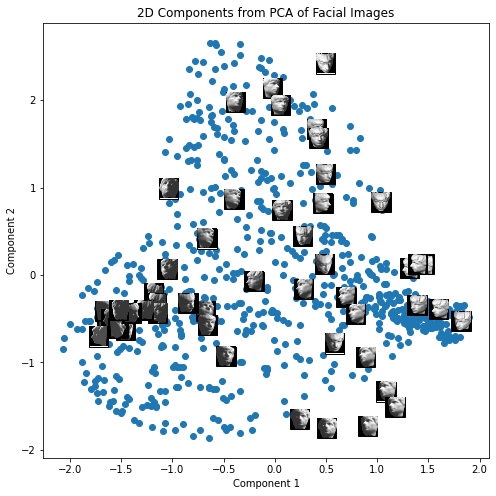

In [27]:
# select random images from dataset
np.random.seed(1)
images_id = np.random.randint(0, len(images), 50)
        
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(dim1, dim2)
ax.set_title('2D Components from PCA of Facial Images')
ax.set_ylabel('Component 2') 
ax.set_xlabel('Component 1') 
    
for i in images_id:
   face_image = images[i].reshape(64, 64).T
   image = OffsetImage(face_image, zoom=0.3, cmap = 'gray')
   annot = AnnotationBbox(image, np.stack((-dim1,dim2)).T[i], pad = 0.01, xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
   ax.add_artist(annot)

plt.show()

PCA is somewhat able to capture the orientation of the faces; however, it is less effective compared to ISOMAP. For example, faces generally facing left and right are clustered nicely in their respective groups, but when it comes to darker images, PCA seems to just group all the images together (the cluster on the very left). Additionally, PCA seems to be unable to differentiate between images looking up or down at all. 